In [10]:
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm

from utils import *
from ODE_utils import *
# from ODE_lag_utils import *

import matplotlib as mpl
import pandas as pd
import multiprocessing

# Set the default font and size
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 16

Due to historical reasons we use rho in the codes instead of phi_pre (rho=R*phi_pre, where R is the total number of resources).

In [4]:
# # generate species pool for simulations on the cluster
# Nseq, Ncout = 500, 500
# Ntrials = 200
# D = 1000
# T_dilute = 24
# gC = 1.0
# R = 4
# rhos = np.linspace(0, 0.8, 101)
# path = "../data/seq_vs_co_init"

# # generate the species pool and corresponding environment
# for rho in tqdm(rhos):
#     experiments = {"D": D, "gC": gC, "R": R, "Nseq":Nseq, "Ncout":Ncout, "initials":[]}
#     for i in range(Ntrials):
#         # generate the pool
#         # seq -- top smart
#         g_seq = generate_g(Nseq, R)
#         permutations = list(itertools.permutations(list(range(1, R+1))))
#         pref_list = np.array(random.choices(permutations, k=Nseq))
#         col = np.argmax(g_seq, axis=1) # find column in g where it's the largest
#         for row_i, row in enumerate(pref_list):
#             index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
#             row[0], row[index] = row[index], row[0]
#         # cout
#         g_cout = generate_g(Ncout, R)
#         # make list of species
#         species_list = []
#         for i in range(Nseq):
#             species_list.append(SeqUt_alt(rho=rho, g_enz=g_seq[i], gC=gC, pref_list=pref_list[i], biomass=0.01, id=i))
#         for i in np.arange(Nseq, Nseq+Ncout):
#             species_list.append(CoUt_alt(rho=rho, g_enz=g_cout[i-Nseq], gC=gC, biomass=0.01, id=i))
        
#         # make the random supply of species -- uniformly sample on symplex
#         cuts = np.sort(np.random.rand(R-1))
#         cuts = np.insert(cuts, 0, 0)
#         cuts = np.insert(cuts, R, 1)
#         Rs = (cuts[1:]-cuts[:-1])*R

#         experiments["initials"].append([species_list, Rs])
#     savefile = os.path.join(path, f"initial_rho={rho}.pkl")
#     pickle.dump(experiments, open(savefile, "wb"))

In [12]:
# load the data for the community outcomes
R = 4
path = "../data/ecol_adv_no_lag"
rhos = np.linspace(0, 0.8, 101)[:80]
# get the result for pairwise
all_frac_diaux_pair = []

frac_diaux_pair = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path, f"pairwise_rho={rho}.pkl"), "rb"))
    basic = data["basic"]
    D, gC, Nseq, Ncout = basic["D"], basic["gC"], basic["Nseq"], basic["Ncout"]
    states = data["end"]["states"]
    ids = [i["ids"] for i in states]
    ids_list = sum(ids, [])
    frac_diaux_pair.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
all_frac_diaux_pair.append(frac_diaux_pair)

all_frac_diaux = []
all_divs = []
all_stratified = []
frac_diaux = []
divs = []
stratified = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path, f"full_rho={rho}.pkl"), "rb"))
    states = data["end"]["states"]
    Nseq = data["basic"]["Nseq"]
    ids = [i["ids"] for i in states]
    ids_list = sum(ids, [])
    frac_diaux.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
    divs.append([min(4, len(i)) for i in ids])
    frac_diaux_strat = []
    lenlist = []
    for num in range(R):
        ids_list = sum([i for i in ids if len(i)==num+1], [])
        if(len(ids_list)>0):
            frac_diaux_strat.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
        else:
            frac_diaux_strat.append(0)
        lenlist.append([len(i) for i in ids].count(num+1))
    stratified.append([lenlist, frac_diaux_strat])
all_frac_diaux.append(frac_diaux)
all_divs.append(divs)
all_stratified.append(stratified)

100%|██████████| 80/80 [01:33<00:00,  1.16s/it]


100%|██████████| 51/51 [02:37<00:00,  3.08s/it]


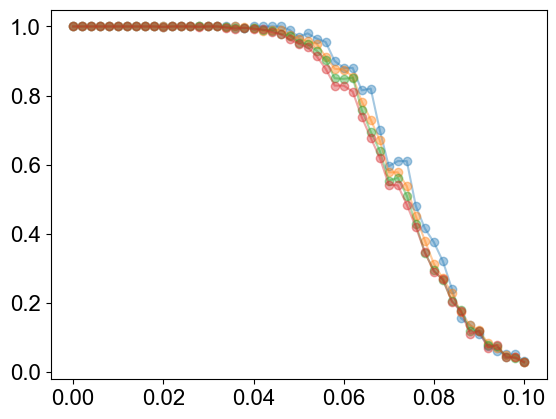

In [3]:
# generate the mock curves from simplification -- how much can it be explained?
R = 4
path = "../data/ecol_adv_no_lag"
rhos = np.linspace(0, 0.4, 51)

def largest_values(lst, n=4):
    sorted_list = sorted(lst, reverse=True)
    return sorted_list[:n]

output = []
for n in np.arange(1, 5):
    all_frac_diaux_winner = []
    k = 0.05
    for rho in tqdm(rhos):
        frac_diaux_winner = []
        data = pickle.load(open(os.path.join(path, f"full_rho={rho}.pkl"), "rb"))
        species = data["end"]["species"]
        for comm in species:
            for spc in comm:
                spc.GetEating(np.ones(4))
            g_list = [spc.GetGrowthRate() for spc in comm]
            winners = [comm[g_list.index(i)] for i in largest_values(g_list, n)]
            frac_diaux_winner.append(len([i for i in winners if i.cat=="Seq"]))
        all_frac_diaux_winner.append(sum(frac_diaux_winner)/n/len(frac_diaux_winner))
    
    plt.plot([i/R for i in rhos], all_frac_diaux_winner, marker="o", alpha=0.4)
    output.append(all_frac_diaux_winner)
pickle.dump(output, open("output_best_by_g.pkl", "wb"))

In [6]:
np.linspace(0, 0.4, 51)

array([0.   , 0.008, 0.016, 0.024, 0.032, 0.04 , 0.048, 0.056, 0.064,
       0.072, 0.08 , 0.088, 0.096, 0.104, 0.112, 0.12 , 0.128, 0.136,
       0.144, 0.152, 0.16 , 0.168, 0.176, 0.184, 0.192, 0.2  , 0.208,
       0.216, 0.224, 0.232, 0.24 , 0.248, 0.256, 0.264, 0.272, 0.28 ,
       0.288, 0.296, 0.304, 0.312, 0.32 , 0.328, 0.336, 0.344, 0.352,
       0.36 , 0.368, 0.376, 0.384, 0.392, 0.4  ])

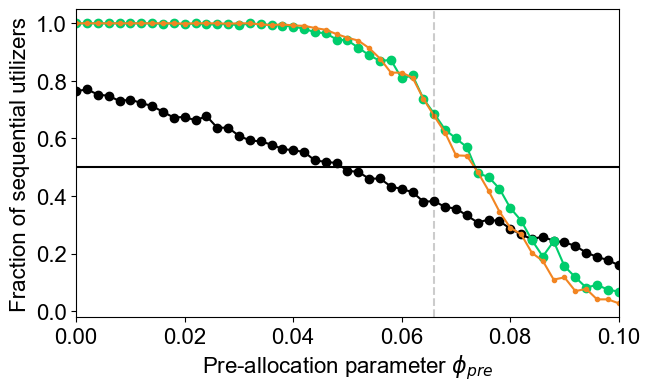

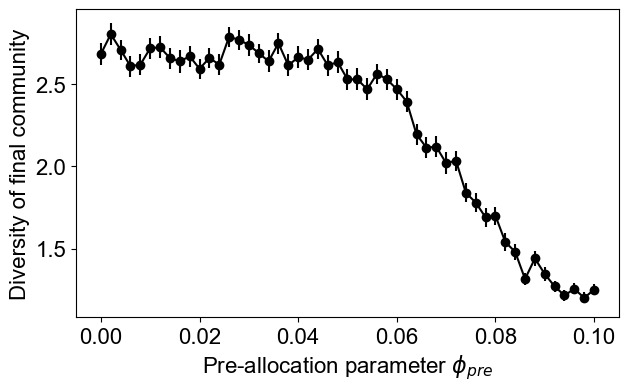

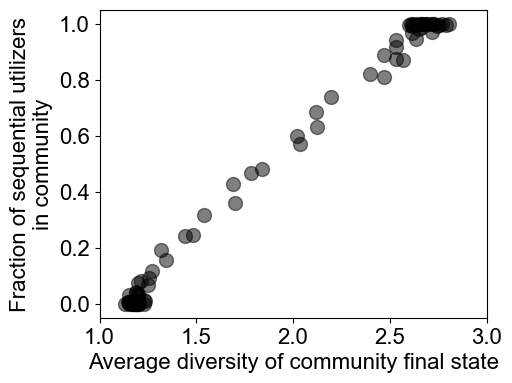

In [14]:
rhos = np.linspace(0, 0.4, 51)

output = pickle.load(open("output_best_by_g.pkl", "rb"))
all_frac_diaux_winner = output[-1]

plt.rcParams["figure.figsize"] = (7,4)
for idx, frac_diaux_pair in enumerate(all_frac_diaux_pair):
    plt.plot([i/R for i in rhos], frac_diaux_pair[:len(rhos)], marker="o", c="k", label="Winner in pairwise")
for idx, frac_diaux in enumerate(all_frac_diaux):
    plt.plot([i/R for i in rhos], frac_diaux[:len(rhos)], marker="o", c="#00CD6C", label="Winner in community")

plt.plot([i/R for i in rhos], all_frac_diaux_winner[:len(rhos)], marker=".", color="#F28522", linestyle="-", label="Top 4 in community")

plt.xlabel("Pre-allocation parameter $\phi_{pre}$")
plt.ylabel("Fraction of sequential utilizers")
plt.axhline(0.5, c='k')
# plt.legend(loc="upper right")
# plt.axvline(0.045, color="k", alpha=0.2, linestyle="--")
# plt.axvline(0.075, color="k", alpha=0.2, linestyle="--")
plt.xlim(0, 0.1)
plt.axvline(0.264/4, color="k", alpha=0.2, linestyle="--")
plt.savefig("../figures/ecol_adv_winners_nolag.pdf", bbox_inches="tight")
plt.show()

rhos = np.linspace(0, 0.4, 51)
alist = [1.0, 0.4, 0.2, 0.1]
for idx, divs in enumerate(all_divs):
    plt.errorbar([i/R for i in rhos], [np.mean(i) for i in divs][:len(rhos)], yerr=[np.std(i)/sqrt(len(i)) for i in divs][:len(rhos)], 
                 marker="o", c="k", alpha = alist[idx])
    
plt.xlabel("Pre-allocation parameter $\phi_{pre}$")
plt.ylabel("Diversity of final community")
# plt.xlim(0, 0.3/R)
plt.show()

plt.rcParams["figure.figsize"] = (5, 4)
plt.scatter([np.mean(i) for i in divs], frac_diaux, color='k', alpha=0.5, s=100)
plt.xlim(1.0, 3.0)
plt.ylabel("Fraction of sequential utilizers\nin community")
plt.xlabel("Average diversity of community final state")
plt.savefig("../figures/div_vs_frac_diaux_nolag.pdf", bbox_inches="tight")
plt.show()

0.4796747967479675 37
[82, 74, 38, 5]


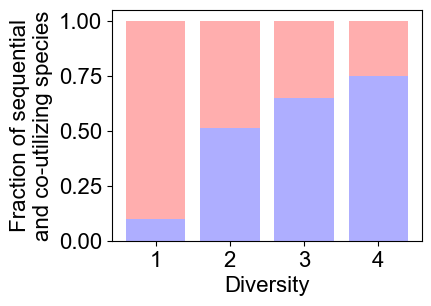

0.46629213483146065 38
[90, 73, 28, 9]


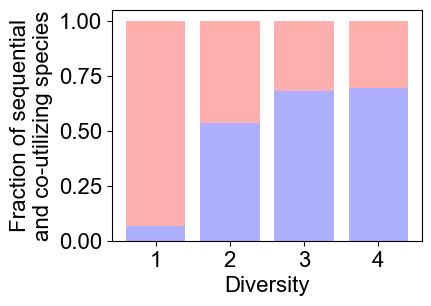

In [17]:
plt.rcParams["figure.figsize"] = (5, 5)
for i in range(51):
    if(0<abs(frac_diaux[i]-0.5)<0.05):
        print(frac_diaux[i], i)
        plt.figure(figsize=(4, 3))
        plt.bar(np.arange(1, 5), [1, 1, 1, 1], color="#ffaeae")
        plt.bar(np.arange(1, 5), stratified[i][1], color = "#aeaeff")
        print(stratified[i][0])
        plt.xticks(np.arange(1, 5))
        # plt.axhline(frac_diaux[i], color='k')
        plt.xlabel("Diversity")
        plt.ylabel("Fraction of sequential\nand co-utilizing species")
        plt.savefig("../figures/div_strat_example_nolag.pdf",bbox_inches = 'tight')
        plt.show()

In [9]:
frac_diaux_pair = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path, f"pairwise_rho={rho}.pkl"), "rb"))
    basic = data["basic"]
    D, gC, Nseq, Ncout = basic["D"], basic["gC"], basic["Nseq"], basic["Ncout"]
    states = data["end"]["states"]
    ids = [i["ids"] for i in states]
    ids_list = sum(ids, [])
    print(len([i for i in ids_list if i<Nseq]), len(ids_list))
    frac_diaux_pair.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
all_frac_diaux_pair.append(frac_diaux_pair)

  8%|▊         | 4/51 [00:00<00:03, 12.09it/s]

1687 2207
1703 2210
1680 2233
1667 2228
1626 2228


 16%|█▌        | 8/51 [00:00<00:03, 13.15it/s]

1622 2206
1598 2211
1602 2247


 20%|█▉        | 10/51 [00:00<00:02, 14.67it/s]

1556 2248
1510 2245
1502 2225


 27%|██▋       | 14/51 [00:01<00:02, 13.01it/s]

1495 2256
1525 2249
1444 2266


 31%|███▏      | 16/51 [00:01<00:02, 14.15it/s]

1453 2279
1391 2283
1342 2262


 39%|███▉      | 20/51 [00:01<00:02, 13.52it/s]

1331 2256
1291 2231
1295 2297
1274 2279


 49%|████▉     | 25/51 [00:01<00:01, 14.02it/s]

1256 2270
1200 2292
1202 2316
1188 2308


 53%|█████▎    | 27/51 [00:01<00:01, 15.23it/s]

1113 2281
1121 2317
1057 2297


 61%|██████    | 31/51 [00:02<00:01, 15.59it/s]

1061 2301
996 2300
972 2289
945 2286


 69%|██████▊   | 35/51 [00:02<00:00, 16.09it/s]

874 2296
880 2302
819 2263
811 2274


 76%|███████▋  | 39/51 [00:02<00:00, 16.41it/s]

750 2254
692 2246
722 2268
709 2267


 84%|████████▍ | 43/51 [00:02<00:00, 16.33it/s]

645 2247
595 2230
561 2242
583 2249


 94%|█████████▍| 48/51 [00:03<00:00, 15.33it/s]

544 2227
528 2205
501 2208
452 2220


100%|██████████| 51/51 [00:03<00:00, 14.61it/s]

412 2181
387 2179
348 2177


In [102]:
all_comp = []
k = k_list[0]
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path_lag, f"full_rho={rho}_lagged_k={k}.pkl"), "rb"))
    states = data["end"]["states"]
    species = data["end"]["species"]
    Nseq = data["basic"]["Nseq"]
    ids = [i["ids"] for i in states]
    diauxs = [[spc for spc in species[idx] if spc.id in ids[idx] and spc.cat=="Seq"] for idx, i in enumerate(states)]
    comps = [len(set([spc.pref[0] for spc in sample]))/len(sample) for sample in diauxs if sample!=[]]
    all_comp.append(comps)

100%|██████████| 51/51 [00:35<00:00,  1.44it/s]


<ErrorbarContainer object of 3 artists>

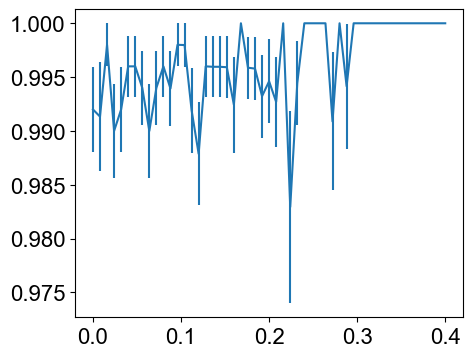

In [103]:
plt.errorbar(rhos, [np.mean(i) for i in all_comp], yerr=[np.std(i)/sqrt(len(i)) for i in all_comp])

In [19]:
rhos[37]/4

0.074

In [8]:
path = "../data/ecol_adv_no_lag"
rhos = np.linspace(0, 0.4, 51)
# get the result for pairwise
all_frac_diaux_pair = []

frac_diaux_pair = []
for rho in tqdm(rhos):
    data = pickle.load(open(os.path.join(path, f"pairwise_rho={rho}.pkl"), "rb"))
    print(data["end"]["species"][0])
    break

  0%|          | 0/51 [00:00<?, ?it/s]

[<ODE_lag_utils.CoUt_alt object at 0x000001399C7D23A0>, <ODE_lag_utils.SeqUt_alt object at 0x0000013996898400>]


In [1]:
import numpy as np
a = np.array([1, 2, 3])
(a>0)*0


array([0, 0, 0])